## 代码实现

在上面的章节中，我们介绍了双目照相机的构造以及其计算深度的原理，接下来我们进入动手学环节，学习如何从一组双目图像中获得视差图。

In [1]:
# 首先clone对应仓库
! git clone https://github.com/boyu-ai/Hands-on-CV.git

Cloning into 'learncv_img'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 81
Receiving objects: 100% (89/89), 14.23 MiB | 1023.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


首先我们读取左右两张图像，并做一个简单的可视化。

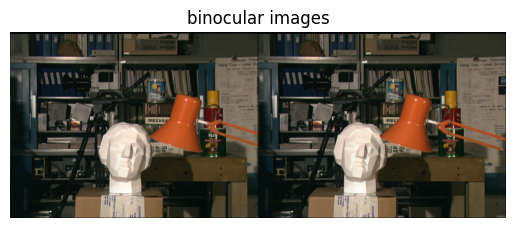

In [25]:
import os
import time
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# 获取左照相机图像
limg_raw = np.asanyarray(Image.open(
    r"./learncv_img/stereo/scene1.row3.col1.ppm"))   
 
# 获取右照相机图像
rimg_raw = np.asanyarray(Image.open(
    r"./learncv_img/stereo/scene1.row3.col3.ppm"))  
  
# 将图像转化为灰度图
limg = cv.cvtColor(limg_raw, cv.COLOR_BGR2GRAY)     
rimg = cv.cvtColor(rimg_raw, cv.COLOR_BGR2GRAY)

# 将图像转化为double类型
limg = np.asanyarray(limg, dtype=np.double)     
rimg = np.asanyarray(rimg, dtype=np.double)

# 定义一个和输入图像大小相同的数组
img_size = np.shape(limg)[0:2]   

# 简单可视化左右图像
plt.figure(dpi=100)                             
plt.title("binocular images")
plt.imshow(np.hstack([limg_raw, rimg_raw]))
plt.axis('off')
plt.show()

接下来，我们实现生成视差图的函数。此函数首先计算左右图像的整体差距，然后对每个像素进行视差搜索，并选择最小匹配代价所对应的视差作为最终视差值。

所用时间: 11.269958972930908


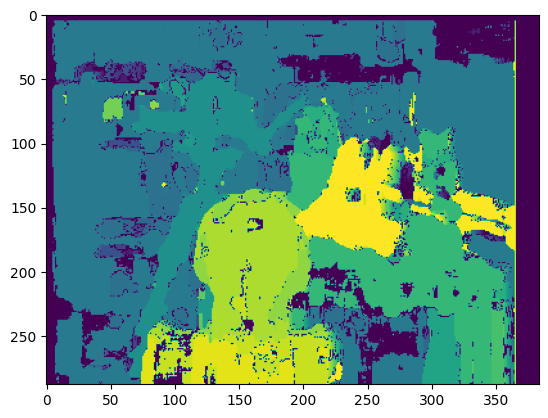

In [ ]:
def get_disp_map(max_D, win_size, img_size, match_mode="SAD"):
    """
    根据左右图像，获取视差图。
    
    参数:
    - max_D: 左右图像之间最大可能的视差值。
    - win_size: 块尺寸。
    - img_size: 双目图像尺寸。
    - match_mode: 匹配模式，可选"SAD"或"SSD"。
    """
    # 记录初始时间
    t1 = time.time()  

    # 初始化视差图                     
    imgDiff = np.zeros((img_size[0], img_size[1], max_D))   

    def SAD(x, y, error_map, win_size):
        return np.sum(error_map[(x - win_size):(x + win_size), 
                                (y - win_size):(y + win_size)])

    def SSD(x, y, error_map, win_size):
        return np.sum(np.square(error_map[
        (x - win_size):(x + win_size), (y - win_size):(y + win_size)]))

    # 遍历所有可能的视差值
    for i in range(0, max_D):
        # 记录视差为i时，左右图像的整体差距
        e = np.abs(rimg[:, 0:(img_size[1]-i)] - limg[:, i:img_size[1]]) 
        e2 = np.zeros(img_size)

        # 遍历所有像素    
        for x in range(0, img_size[0]):
            for y in range(0, img_size[1]):
                # 根据匹配模式计算匹配代价
                if match_mode == "SAD":
                    # 计算SAD值
                    e2[x, y] = SAD(x, y, e, win_size) 
                elif match_mode == "SSD":
                    # 计算SSD值
                    e2[x, y] = SSD(x, y, e, win_size) 
                else:
                    raise NotImplemented
        
        # 将匹配代价存储到imgDiff中  
        imgDiff[:, :, i] = e2

    # 初始化视差图
    dispMap = np.zeros(img_size)    
    for x in range(0, img_size[0]):
        for y in range(0, img_size[1]):
            # 对匹配代价进行排序
            val = np.sort(imgDiff[x, y, :])  
            
            # 简单判断是否出了边界
            if np.abs(val[0]-val[1]) > 10:     
                # 找到最小匹配代价的视差索引
                val_id = np.argsort(imgDiff[x, y, :])      
                # 将视差值映射到 0-255 之间
                dispMap[x, y] = val_id[0] / max_D * 255        

    # 打印运行时间
    print("所用时间:", time.time() - t1)

    # 显示视差图
    plt.figure("视差图")
    plt.imshow(dispMap)
    plt.show()

    # 返回视差图
    return dispMap
    
# 最大视差
max_D = 25   
# 滑动窗口大小
win_size = 5         
# 可视化SAD匹配效果，块尺寸为5像素
_ = get_disp_map(max_D, win_size, img_size) 

通过生成双目图像的视差图，我们可以观察到一些直观的现象，比如台灯在视差图中的亮度较高，这表明其视差值相对较大；而背景部分的亮度较低，表示视差值较小。视差图中的亮度变化直接反映了物体与相机之间的相对深度差异：亮度较高的区域（视差大）意味着物体相对较近，亮度较低的区域（视差小）则表明物体相对较远。因此，利用视差图，我们可以有效地估计场景中各个物体的深度信息。

接下来我们看看调大块匹配的尺寸的效果:

所用时间: 14.947252035140991


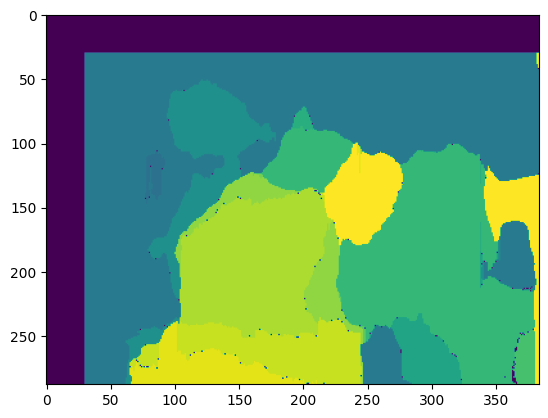

In [27]:
# 测试更大的块尺寸
win_size = 30 
# SAD匹配效果，块尺寸为30像素
_ = get_disp_map(max_D, win_size, img_size) 

不难发现，块尺寸越大，预测出的视差图更加平滑，细节丢失更加严重，同时计算的时间也增加了。

接下来我们来看看SSD的效果。

所用时间: 13.194314956665039


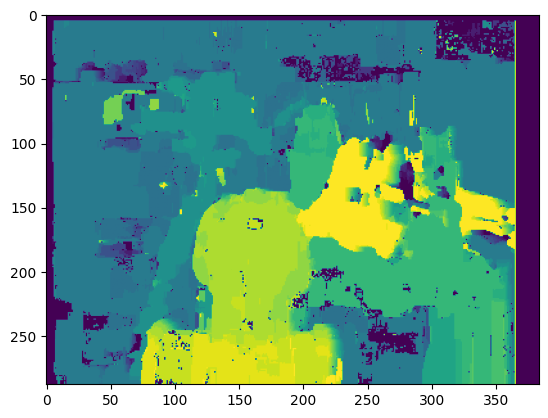

In [28]:
win_size = 5
# SSD匹配效果，块尺寸为5像素
_ = get_disp_map(max_D, win_size, img_size, match_mode="SSD") 

所用时间: 18.293694019317627


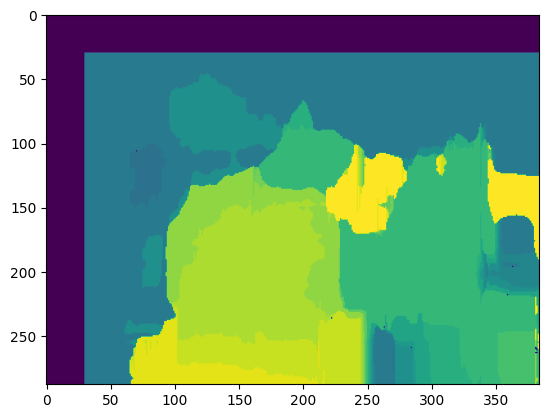

In [29]:
win_size = 30
# SSD匹配效果，块尺寸为30像素
_ = get_disp_map(max_D, win_size, img_size, match_mode="SSD") 

对比SAD和SSD的效果，我们可以发现，SSD保留了更多细节，但是同时它也花费了更多的时间。